In [1]:
import numpy as np
import pandas as pd
from stocktrends import Renko
import statsmodels.api as sm
import yfinance as yf
import datetime as dt
import copy
import matplotlib.pyplot as plt

In [2]:

def STO_RSI(DF,n,m):
    "function to calculate RSI"
    df = DF.copy()
    df['delta']=df['close'] - df['close'].shift(1) #used close instead of Adj Close since we are passing it inside renko and renko has close as itickers column name
    df['gain']=np.where(df['delta']>=0,df['delta'],0)
    df['loss']=np.where(df['delta']<0,abs(df['delta']),0)
    avg_gain = []
    avg_loss = []
    gain = df['gain'].tolist()
    loss = df['loss'].tolist()
    for i in range(len(df)):
        if i < n:
            avg_gain.append(np.NaN)
            avg_loss.append(np.NaN)
        elif i == n:
            avg_gain.append(df['gain'].rolling(n).mean().tolist()[n])
            avg_loss.append(df['loss'].rolling(n).mean().tolist()[n])
        elif i > n:
            avg_gain.append(((n-1)*avg_gain[i-1] + gain[i])/n)
            avg_loss.append(((n-1)*avg_loss[i-1] + loss[i])/n)
    df['avg_gain']=np.array(avg_gain)
    df['avg_loss']=np.array(avg_loss)
    df['RS'] = df['avg_gain']/df['avg_loss']
    df['RSI'] = 100 - (100/(1+df['RS']))
    
    #calculation of stochRSI
    df['max rsi'] = df['RSI'].rolling(n).max()
    df['min rsi'] = df['RSI'].rolling(n).min()
    df['StochRSI'] = (df['RSI']-df['min rsi'])/(df['max rsi']-df['min rsi'])
    df['%K'] = df['StochRSI'].rolling(m).mean()
    df['%D'] = df['%K'].rolling(m).mean() 
    #df['%K'] = df['StochRSI'].ewm(span=3,min_periods=3).mean() #this is exponential mean
    #df['%D'] = df['%K'].ewm(span=3,min_periods=3).mean()
    return (df["%K"],df["%D"])

def ATR(DF,n=14):
    "function to calculate True Range and Average True Range"
    df = copy.deepcopy(DF)
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2

def renko_DF_STO_RSI(DF):
    "function to convert ohlc data into renko bricks"
    df = DF.copy()
    df.reset_index(inplace=True)
    df = df.iloc[:,[0,1,2,3,4,5]]
    df.columns = ["date","open","high","low","close","volume"]
    df2 = Renko(df)
    #df2.brick_size = 0.5
    df2.brick_size = max(1,round(ATR(DF)["ATR"][-1],1))
    renko_df = df2.get_ohlc_data()
    renko_df["bar_num"] = np.where(renko_df["uptrend"]==True,1,np.where(renko_df["uptrend"]==False,-1,0))
    renko_df['%K'] = STO_RSI(renko_df,14,3)[0]
    renko_df['%D'] = STO_RSI(renko_df,14,3)[1]
    for i in range(1,len(renko_df["bar_num"])):
        if renko_df["bar_num"][i]>0 and renko_df["bar_num"][i-1]>0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
        elif renko_df["bar_num"][i]<0 and renko_df["bar_num"][i-1]<0:
            renko_df["bar_num"][i]+=renko_df["bar_num"][i-1]
    renko_df.drop_duplicates(subset="date",keep="last",inplace=True)
    return renko_df

def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = df["ret"].cumsum().apply(np.exp)
    n = len(df)/(252*75)
    CAGR = (df["cum_return"])**(1/n) - 1
    return CAGR.iloc[-1]
#(df.loc[:,"cum_return"].iloc[-1]**(1/n)) - 1

def volatility(DF):
    "function to calculate Annualized volatility of a trading strategy"
    df = DF.copy()
    vol = (df["ret"].apply(np.exp)-1).std() * np.sqrt(252*75)
    return vol

def sharpe(DF,rf=0.06):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = df["ret"].cumsum().apply(np.exp)
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd


In [3]:
tickers = [ 'MSFT', 'AMZN', 'TSLA', 'INTC']

ohlc_intraday={}
for t in tickers:
    ohlc_intraday[t]=yf.download(t, period='1mo',interval='5m')
    ohlc_intraday[t].dropna(inplace=True,how="any")
    del ohlc_intraday[t]['Close']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**Backtesting**


In [4]:
#Merging renko df with original ohlc df

ohlc_renko = {}
df = copy.deepcopy(ohlc_intraday)
tickers_signal = {}
tickers_ret = {}
for t in tickers:
    print("merging for ",t)
    renko = renko_DF_STO_RSI(df[t])
    renko.columns = ["Date","open","high","low","close","uptrend","bar_num","%K","%D"]
    df[t]["Date"] = df[t].index
    ohlc_renko[t] = df[t].merge(renko.loc[:,["Date","bar_num","%K","%D"]],how="outer",on="Date")
    ohlc_renko[t]["bar_num"].fillna(method='ffill',inplace=True)
    ohlc_renko[t]["%K"].fillna(method='ffill',inplace=True)
    ohlc_renko[t]["%D"].fillna(method='ffill',inplace=True)
    ohlc_renko[t].dropna(how='any', inplace=True)
    ohlc_renko[t]["bar_ret"] = np.log(ohlc_renko[t]['Adj Close']/ohlc_renko[t]['Adj Close'].shift(1))
    tickers_signal[t] = ""
    #tickers_ret[t] = []


merging for  MSFT


merging for  AMZN


merging for  TSLA


merging for  INTC


calculating daily returns for  MSFT
calculating daily returns for  AMZN
calculating daily returns for  TSLA
calculating daily returns for  INTC


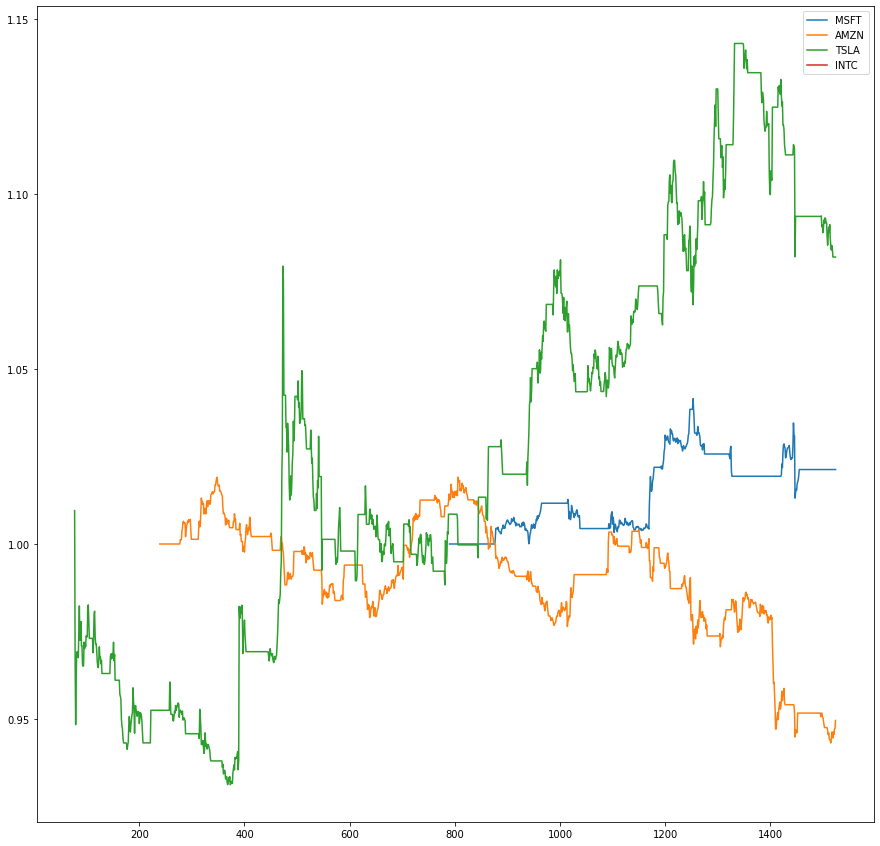

In [5]:
#Identifying signals and calculating daily return   

for t in tickers:
    print("calculating daily returns for ",t)
    a= ohlc_renko[t]["bar_num"]>=2
    b= ohlc_renko[t]["%K"]>ohlc_renko[t]["%D"]
    c=ohlc_renko[t]["bar_num"]<=-2
    d=ohlc_renko[t]["%K"]<ohlc_renko[t]["%D"]
    ohlc_renko[t]["sig"] = np.where(a&b==True,1,np.where(c&d==True,-1,0))
    ohlc_renko[t]["strategy_returns" ] = ohlc_renko[t]["sig"].shift(1) * ohlc_renko[t]["bar_ret"]
        
    ohlc_renko[t]["strategy_returns"].dropna().cumsum().apply(np.exp).plot(figsize=(15,15))
    plt.legend(tickers)
    #np.exp(ohlc_renko[t]["strategy_returns"].mean() * 252*75) - 1
    

In [6]:
#calculating overall strategy's KPIs

strategy_df = pd.DataFrame()
for t in tickers:
    strategy_df[t] =  ohlc_renko[t]["strategy_returns"]
strategy_df["ret"] = strategy_df.mean(axis=1, skipna=True)
print("Portfolio CAGR = ",CAGR(strategy_df))
print("Portfolio Sharpe ratio = ",sharpe(strategy_df))
print("Portfolio Max DD = ",max_dd(strategy_df))

Portfolio CAGR =  0.2796788463273501
Portfolio Sharpe ratio =  1.2748005287135067
Portfolio Max DD =  0.03351506850393044
